## Import necessary library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## Load dataset

In [2]:
df = pd.read_csv('Sample - Superstore.csv', encoding='latin-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## EDA

In [3]:
# check null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [4]:
# change data types
df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df['Postal Code'] = str(df['Postal Code'])

In [5]:
# check duplicates
df[df.duplicated()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [6]:
# drop row id
df = df.drop(columns=['Row ID'])
df.describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


In [49]:
# Simplified df
simplified_df = df[['State', 'Segment', 'Category', 'Sales', 'Profit']]

# group by state
state_df = simplified_df.groupby('State').sum().head(5).sort_values('Sales', ascending=False).reset_index()
state_df

,State,Sales,Profit
0,California,457687.6315,76381.3871
1,Arizona,35282.0010,-3427.9246
2,Colorado,32108.1180,-6527.8579
3,Alabama,19510.6400,5786.8253
4,Arkansas,11678.1300,4008.6871


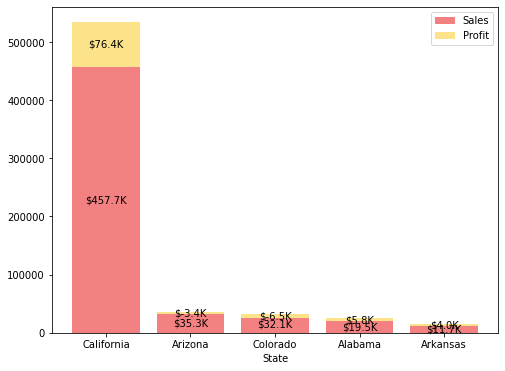

In [51]:
# create stacked bar chart for State
fig, ax = plt.subplots(figsize=[8, 6])

state_sales = ax.bar(x=state_df['State'], height=state_df['Sales'], color='#F38181', label='Sales')
state_profit = ax.bar(x=state_df['State'], height=state_df['Profit'], bottom=state_df['Sales'], color='#FCE38A', label='Profit')

ax.set_xlabel('State')
ax.legend()
ax.bar_label(state_sales, labels=[f'${x/1000:,.1f}K' for x in state_sales.datavalues], label_type='center')
ax.bar_label(state_profit,  labels=[f'${x/1000:,.1f}K' for x in state_profit.datavalues], label_type='center')
plt.show()

In [52]:
# group by segment
segment_df = simplified_df.groupby('Segment').sum().sort_values('Sales', ascending=False).reset_index()
segment_df

,Segment,Sales,Profit
0,Consumer,1.161401e+06,134119.2092
1,Corporate,7.061464e+05,91979.1340
2,Home Office,4.296531e+05,60298.6785


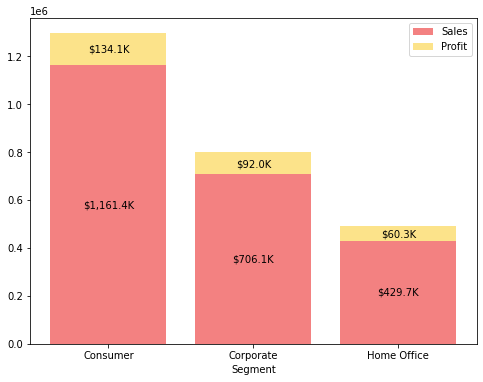

In [53]:
# create stacked bar chart for Cust Segment
fig, ax = plt.subplots(figsize=[8, 6])

segment_sales = ax.bar(x=segment_df['Segment'], height=segment_df['Sales'], color='#F38181', label='Sales')
segment_profit = ax.bar(x=segment_df['Segment'], height=segment_df['Profit'], bottom=segment_df['Sales'], color='#FCE38A', label='Profit')

ax.set_xlabel('Segment')
ax.legend()
ax.bar_label(segment_sales, labels=[f'${x/1000:,.1f}K' for x in segment_sales.datavalues], label_type='center')
ax.bar_label(segment_profit,  labels=[f'${x/1000:,.1f}K' for x in segment_profit.datavalues], label_type='center')
plt.show()

In [54]:
# group by category
category_df = simplified_df.groupby('Category').sum().sort_values('Sales', ascending=False).reset_index()
category_df

,Category,Sales,Profit
0,Technology,836154.0330,145454.9481
1,Furniture,741999.7953,18451.2728
2,Office Supplies,719047.0320,122490.8008


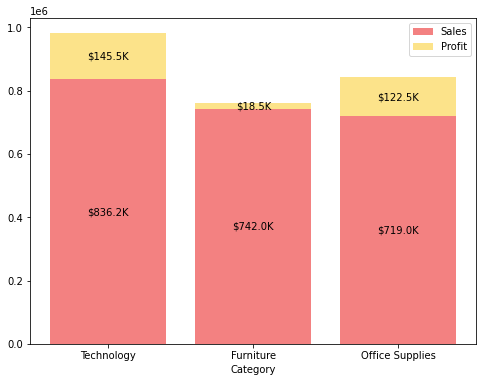

In [55]:
# create stacked bar chart for Category
fig, ax = plt.subplots(figsize=[8, 6])

category_sales = ax.bar(x=category_df['Category'], height=category_df['Sales'], color='#F38181', label='Sales')
category_profit = ax.bar(x=category_df['Category'], height=category_df['Profit'], bottom=category_df['Sales'], color='#FCE38A', label='Profit')

ax.set_xlabel('Category')
ax.legend()
ax.bar_label(category_sales, labels=[f'${x/1000:,.1f}K' for x in category_sales.datavalues], label_type='center')
ax.bar_label(category_profit,  labels=[f'${x/1000:,.1f}K' for x in category_profit.datavalues], label_type='center')
plt.show()

## Monthly Sales

In [7]:
df['Order Date'] = df['Order Date'].dt.to_period('M')
monthly_sales = df.groupby('Order Date').sum().reset_index()
monthly_sales.head()

,Order Date,Sales,Quantity,Discount,Profit
0,2014-01,14236.895,284,10.00,2450.1907
1,2014-02,4519.892,159,8.10,862.3084
2,2014-03,55691.009,585,26.30,498.7299
3,2014-04,28295.345,536,14.85,3488.8352
4,2014-05,23648.287,466,18.95,2738.7096


In [8]:
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()
monthly_sales.head()

,Order Date,Sales,Quantity,Discount,Profit
0,2014-01-01,14236.895,284,10.00,2450.1907
1,2014-02-01,4519.892,159,8.10,862.3084
2,2014-03-01,55691.009,585,26.30,498.7299
3,2014-04-01,28295.345,536,14.85,3488.8352
4,2014-05-01,23648.287,466,18.95,2738.7096


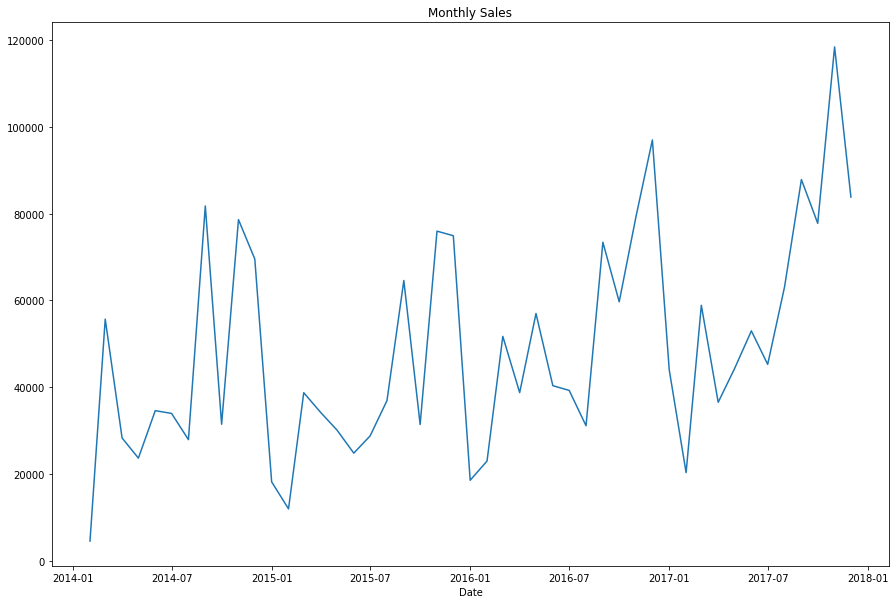

In [44]:
# visualize monthly sales and profit
plt.figure(figsize=[15, 10])
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'])
plt.xlabel('Date')
plt.title('Monthly Sales')
plt.show()

In [10]:
monthly_sales['Sales Diff'] = monthly_sales['Sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,Order Date,Sales,Quantity,Discount,Profit,Sales Diff
1,2014-02-01,4519.8920,159,8.10,862.3084,-9717.0030
2,2014-03-01,55691.0090,585,26.30,498.7299,51171.1170
3,2014-04-01,28295.3450,536,14.85,3488.8352,-27395.6640
4,2014-05-01,23648.2870,466,18.95,2738.7096,-4647.0580
5,2014-06-01,34595.1276,521,23.22,4976.5244,10946.8406


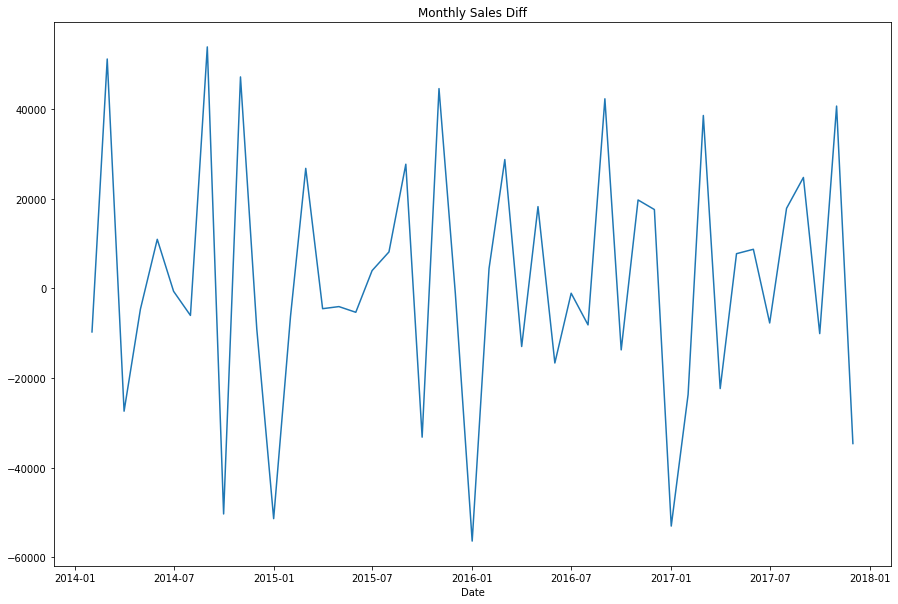

In [11]:
# visualize sales and profit diff
# visualize monthly sales and profit
plt.figure(figsize=[15, 10])
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales Diff'])
plt.xlabel('Date')
plt.title('Monthly Sales Diff')
plt.show()

In [12]:
sales_data = monthly_sales[['Sales Diff']]
sales_data.head()

,Sales Diff
1,-9717.0030
2,51171.1170
3,-27395.6640
4,-4647.0580
5,10946.8406


In [14]:
for i in range(1, 13):
    col_name = 'Month-' + str(i)
    sales_data[col_name] = sales_data['Sales Diff'].shift(i)

sales_data = sales_data.dropna().reset_index(drop=True)
sales_data.head()

<ipython-input-14-8e4db20dbe1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data[col_name] = sales_data['Sales Diff'].shift(i)


,Sales Diff,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
0,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4647.0580,-27395.6640,51171.1170,-9717.0030
1,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4647.0580,-27395.6640,51171.1170
2,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4647.0580,-27395.6640
3,-4063.5220,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406,-4647.0580
4,-5334.3945,-4063.5220,-4531.0435,26774.8410,-6222.6646,-51371.5449,-9083.0962,47175.3237,-50323.9578,53867.8823,-6036.9245,-648.7346,10946.8406


In [16]:
# split test and train sales data
train_sales_data = sales_data[:-12]
test_sales_data = sales_data[-12:]
print('Train sales data shape: ', train_sales_data.shape)
print('Test sales data shape: ', test_sales_data.shape)

Train sales data shape:  (23, 13)
Test sales data shape:  (12, 13)


In [18]:
# scale feature values for sales data
scaler = MinMaxScaler(feature_range=(-1, 1))

# sales data
scaler.fit(train_sales_data)
train_sales_data = scaler.transform(train_sales_data)
test_sales_data = scaler.transform(test_sales_data)

In [19]:
# sales data
X_train_sales, y_train_sales = train_sales_data[:, 1:], train_sales_data[:, 0:1]
X_test_sales, y_test_sales = test_sales_data[:, 1:], test_sales_data[:, 0:1]

y_train_sales = y_train_sales.ravel()
y_test_sales = y_test_sales.ravel()

print('X_train_sales shape: ', X_train_sales.shape)
print('y_train_sales shape: ', y_train_sales.shape)
print('X_test_sales shape: ', X_test_sales.shape)
print('y_test_sales shape: ', y_test_sales.shape)

X_train_sales shape:  (23, 12)
y_train_sales shape:  (23,)
X_test_sales shape:  (12, 12)
y_test_sales shape:  (12,)


In [20]:
# reshape for LSTM
X_train_sales_lstm = X_train_sales.reshape(X_train_sales.shape[0], 1, X_train_sales.shape[1])
X_test_sales_lstm = X_test_sales.reshape(X_test_sales.shape[0], 1, X_test_sales.shape[1])

## Create LSTM Model

In [23]:
# LSTM model for sales data

model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train_sales_lstm.shape[1], X_test_sales_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    272       
_________________________________________________________________
dense (Dense)                (1, 10)                   50        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    11        
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# fitting model to sales dataset
epoch = 200 
batch_size = 1
history = model.fit(X_train_sales_lstm, y_train_sales, 
            epochs=epoch,
            batch_size=batch_size, 
            validation_data=(X_test_sales_lstm, y_test_sales),
            verbose=1)

Epoch 1/200
23/23 [==============================] - 3s 33ms/step - loss: 0.2426 - val_loss: 0.2971
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2298 - val_loss: 0.2881
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2237 - val_loss: 0.2796
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2136 - val_loss: 0.2762
Epoch 5/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2080 - val_loss: 0.2720
Epoch 6/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2027 - val_loss: 0.2675
Epoch 7/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1957 - val_loss: 0.2647
Epoch 8/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1904 - val_loss: 0.2627
Epoch 9/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1860 - val_loss: 0.2618
Epoch 10/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1821 - val_loss: 0.2606
Epoch 11

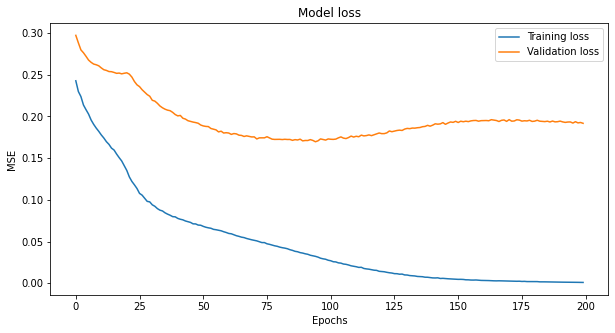

In [26]:
# plot loss
loss_val = pd.DataFrame(history.history)
plt.figure(figsize=(10, 5))
plt.plot(loss_val.index, loss_val.loss, label = 'Training loss')
plt.plot(loss_val.index, loss_val.val_loss, label = 'Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [33]:
# make predictions
sales_pred_result = model.predict(X_test_sales_lstm, batch_size=1)

sales_pred_result = sales_pred_result.reshape(-1, 1)
sales_pred_result_set = np.concatenate([sales_pred_result, X_test_sales], axis=1)
sales_pred_result_set = scaler.inverse_transform(sales_pred_result_set)
sales_pred_result_set.shape


(12, 13)

In [40]:
sales_dates = monthly_sales['Order Date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

act_sales = monthly_sales['Sales'][-13:].to_list()

result_list_sales = []
for index in range(0, len(sales_pred_result_set)):
    result_list_sales.append(sales_pred_result_set[index][0] + act_sales[index])
lstm_sales_pred = pd.Series(result_list_sales, name = 'lstm_sales_pred')
predict_df = predict_df.merge(lstm_sales_pred, left_index=True, right_index=True)

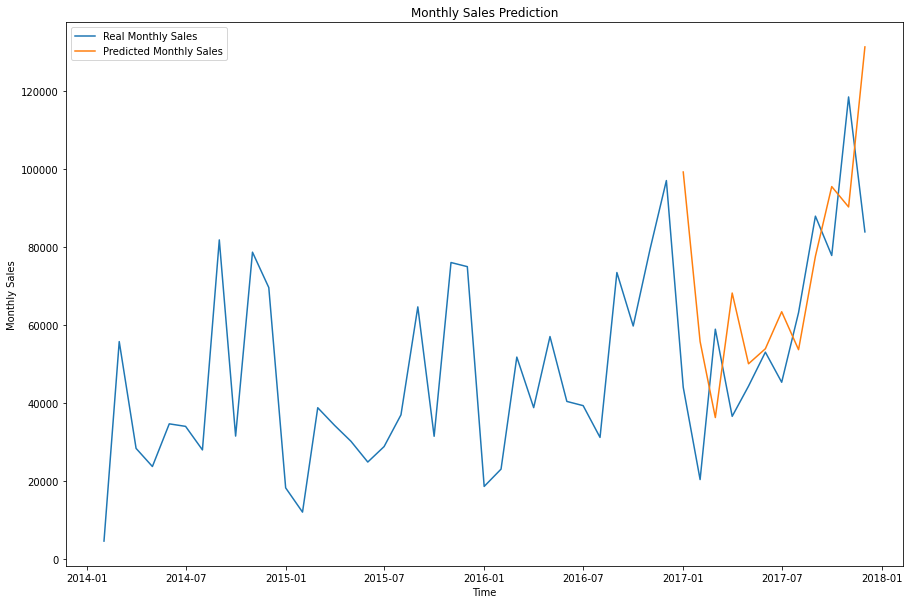

In [41]:
# visualize predictions vs real

plt.figure(figsize=(15, 10))
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'], label = 'Real Monthly Sales')
plt.plot(predict_df['Order Date'], predict_df['lstm_sales_pred'], label = 'Predicted Monthly Sales')
plt.title('Monthly Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Monthly Sales')
plt.legend()
plt.show()